In [26]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.special import iv
from scipy.optimize import minimize


<a id='sec1'></a>
# Brownian motion

Let us simulate some Brownian paths.    
Remember that the (standard) Brownian motion $\{X_t\}_{t\geq 0}$ is a continuous time stochastic process, that satisfies the following properties:
- $X_{0} = 0$.
- The increments are stationary and independent. (see **A3** for the definition)
- It is a martingale.
- It has continuous paths, but nowhere differentiable.
- $X_t - X_s \sim \mathcal{N}(0,t-s)$ for $t\geq s \geq 0$.

For more info see here [wiki](https://en.wikipedia.org/wiki/Brownian_motion).

In our simulation, each increments is such that:

$$ X_{t_i+\Delta t} - X_{t_i} = \Delta X_i \sim \mathcal{N}(\mu \Delta t,\, \sigma^2 \Delta t). $$

The process at time T is given by $X_T = \sum_i \Delta X_i$ and follows the distribution:

$$ X_T \sim \mathcal{N}(\mu T,\, \sigma^2 T). $$

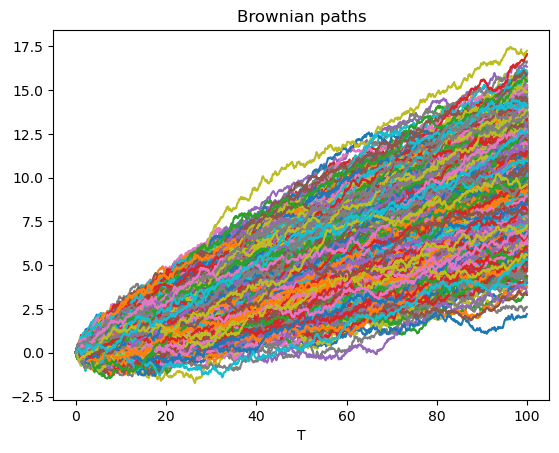

In [21]:
# scipy.stats uses numpy.random to generate its random numbers
np.random.seed(seed=42)

paths = 4000  # number of paths
steps = 1000  # number of time steps

mu = 0.1  # drift
sig = 0.2  # diffusion coefficient or volatility
T = 100
T_vec, dt = np.linspace(0, T, steps, retstep=True)

X0 = np.zeros((paths, 1))  # each path starts at zero
increments = ss.norm.rvs(loc=mu * dt, scale=np.sqrt(dt) * sig, size=(paths, steps - 1))

X = np.concatenate((X0, increments), axis=1).cumsum(1)

plt.plot(T_vec, X.T)
plt.title("Brownian paths")
plt.xlabel("T")
plt.show()

<a id='sec1'></a>
# Merton Jump-Diffusion process

The Merton process is described by the following equation:

\begin{equation}
X_t = \mu t + \sigma W_t + \sum_{i=1}^{N_t} Y_i, 
\end{equation}

where $N_t \sim Po(\lambda t)$ is a Poisson random variable counting the jumps of $X_t$ in $[0,t]$, and 

$$Y_i \sim \mathcal{N}(\alpha, \xi^2)$$ 

are the sizes of the jumps.     
In the following I indicate $\mu \to$ `mu`, $\sigma \to $ `sig`, $\lambda \to $ `lam`, $\alpha \to $ `muJ` and $\xi \to $ `sigJ`.

In [27]:
mu = 0.05  # drift
sig = 0.2  # diffusion coefficient
lam = 1.2  # jump activity
muJ = 0.15  # jump mean size
sigJ = 0.5  # jump std deviation
T = 2  # terminal time
N = 1000000  # number of random variables

In [28]:
np.random.seed(seed=42)
W = ss.norm.rvs(0, 1, N)  # The normal RV vector
P = ss.poisson.rvs(lam * T, size=N)  # Poisson random vector
Jumps = np.asarray([ss.norm.rvs(muJ, sigJ, i).sum() for i in P])  # Jumps vector
X_T = mu * T + np.sqrt(T) * sig * W + Jumps  # Merton process

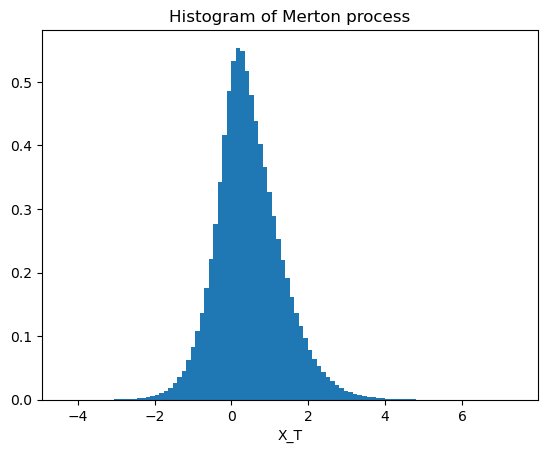

In [29]:
#plot the histogram
plt.hist(X_T, bins=100, density=True)
plt.title("Histogram of Merton process")
plt.xlabel("X_T")
plt.show()

In [41]:
#calculate S_t
S0 = 0.0001
S_T = S0 * np.exp(X_T)
plt.hist(S_T, bins=1000000, density=True)

KeyboardInterrupt: 

In [ ]:
#define a european call payoff function
def call_payoff(S, K):
    return np.maximum(S - K, 0)

#define a european put payoff function
def put_payoff(S, K):
    return np.maximum(K - S, 0)



In [22]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    S: Initial stock price
    K: Option strike price
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    option_type: Type of option ('call' or 'put')
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = (S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        option_price = (K * np.exp(-r * T) * ss.norm.cdf(-d2, 0.0, 1.0) - S * ss.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'")
    
    return option_price

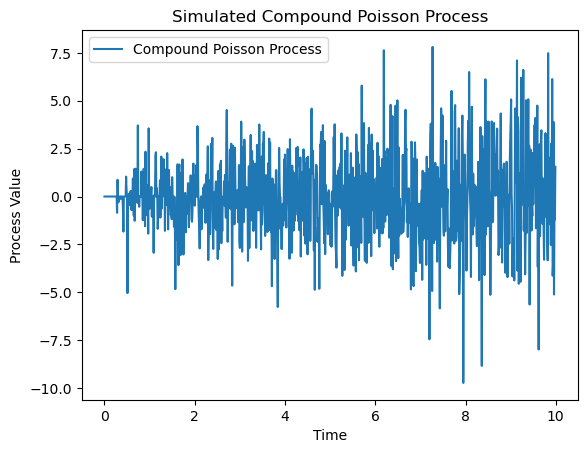

In [ ]:
# Parameters
lambda_val = 1.0  # Poisson arrival rate of jumps
jump_mean = 0.0  # Mean of jump sizes
jump_std = 1.0  # Standard deviation of jump sizes
T = 10  # Total time
dt = 0.01  # Time increment

# Simulate Compound Poisson Process
times = np.arange(0, T, dt)
X_t = np.zeros_like(times)
for i, t in enumerate(times[1:], start=1):
    # Number of jumps in [0, t], Poisson distributed
    num_jumps = np.random.poisson(lambda_val * t)
    
    # Generate jump sizes, normally distributed for this example
    jumps = np.random.normal(jump_mean, jump_std, num_jumps)
    
    X_t[i] = np.sum(jumps)

# Plot the simulated process
plt.plot(times, X_t, label='Compound Poisson Process')
plt.xlabel('Time')
plt.ylabel('Process Value')
plt.title('Simulated Compound Poisson Process')
plt.legend()
plt.show()


In [ ]:
def monte_carlo_levy_control_variate(S, K, T, r, lambda_val, jump_mean, jump_std, sigma, num_paths):
    dt = 0.01  # Time increment
    times = np.arange(0, T, dt)
    option_payoffs = np.zeros(num_paths)
    bs_prices = np.zeros(num_paths)
    
    for i in range(num_paths):
        X_t = 0  # Initialize the Lévy process value
        for t in times[1:]:
            # Simulate the Lévy process (e.g., compound Poisson process)
            num_jumps = np.random.poisson(lambda_val * dt)
            jumps = np.random.normal(jump_mean, jump_std, num_jumps)
            X_t += np.sum(jumps)
            
            # Simulate the stock price under the Lévy model
            S_t = S * np.exp(r * t + X_t)
        
        # Calculate option payoff at maturity
        option_payoffs[i] = np.maximum(S_t - K, 0)
        
        # Calculate Black-Scholes price as a control variate
        bs_prices[i] = black_scholes_price(S, K, T, r, sigma, option_type='call')
        
    # Compute optimal alpha for control variate adjustment
    cov_matrix = np.cov(option_payoffs, bs_prices)
    alpha_opt = -cov_matrix[0, 1] / cov_matrix[1, 1]
    
    # Adjust option payoffs using Black-Scholes control variate
    adjusted_payoffs = option_payoffs + alpha_opt * (bs_prices - np.mean(bs_prices))
    
    # Estimate option price
    option_price_estimate = np.exp(-r * T) * np.mean(adjusted_payoffs)
    
    return option_price_estimate


In [ ]:
monte_carlo_levy_control_variate(S=100, K=100, T=10, r=0.05, lambda_val=1.0, jump_mean=0.0, jump_std=1.0, sigma=0.2, num_paths=10000)

34882.84825076582